In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

from sklearn.cluster import KMeans
from collections import Counter
import skimage.morphology


In [2]:
def read_data(data_path, data_type):
    if data_type == 'before':
        data_path = os.path.join(data_path, 'A')
    elif data_type == 'after':
        data_path = os.path.join(data_path, 'B')
    elif data_type == 'label':
        data_path = os.path.join(data_path, 'label')
    else:
        print('data_type is not correct')
        return None

    data = []
    for file in os.listdir(data_path):
        img = cv2.imread(os.path.join(data_path, file))
        data.append(img)
    return data

# display images {before, after, labels}
def display_images(before, after, labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    plt.show()

In [3]:
def plot_row(images, titles):
    fig, ax = plt.subplots(1, len(images), figsize=(10, 20))
    ax[0].imshow(images[0].astype("uint8"))
    ax[0].set_title(titles[0])
    ax[0].axis("off")
    for i in range(len(images) - 1):
        ax[i+1].imshow(images[i + 1])
        ax[i+1].set_title(titles[i + 1])
        ax[i+1].axis("off")
    plt.tight_layout()
    plt.show()

In [4]:
training_path = '../trainval/'

In [5]:
before_images = read_data(training_path,'before')
after_images = read_data(training_path, 'after')
labels = read_data(training_path,'label')

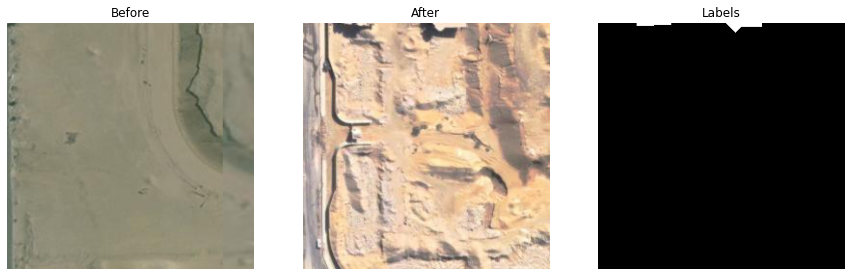

In [6]:
index = 0
# print first image in before_images, after_images, and labels in the same row
display_images(before_images[index], after_images[index], labels[index])

## PCA with Kmeans

In [7]:
def find_vector_set(diff_image, new_size):
    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25),25))
    while i < vector_set.shape[0]:
        while j < new_size[1]:
            k = 0
            while k < new_size[0]:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1

    mean_vec   = np.mean(vector_set, axis = 0)
    # Mean normalization
    vector_set = vector_set - mean_vec   
    return vector_set, mean_vec

In [8]:
def find_FVS(EVS, diff_image, mean_vec, new):
    i = 2
    feature_vector_set = []
    while i < new[1] - 2:
        j = 2
        while j < new[0] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
 
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    print("[INFO] Feature vector space size", FVS.shape)
    return FVS

In [9]:
def clustering(FVS, components, new):
    kmeans = KMeans(components, verbose=0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count = Counter(output)
 
    least_index = min(count, key=count.get)
    change_map = np.reshape(output,(new[1] - 4, new[0] - 4))
    return least_index, change_map

In [10]:
# Define the output directory
out_dir = "output"

# Check if the output directory exists, if not, create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [11]:
import matplotlib.pyplot as plt

# display images {before, after, labels, predicted_label}
def display_images(before, after, labels, predicted_label):
    # Convert images to uint8
    before = before.astype(np.uint8)
    after = after.astype(np.uint8)
    labels = labels.astype(np.uint8)
    predicted_label = predicted_label.astype(np.uint8)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    axs[3].imshow(predicted_label, cmap='gray')
    axs[3].set_title('Predicted Labels')
    axs[3].axis('off')
    plt.show()


In [12]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

[INFO] Feature vector space size (63001, 25)


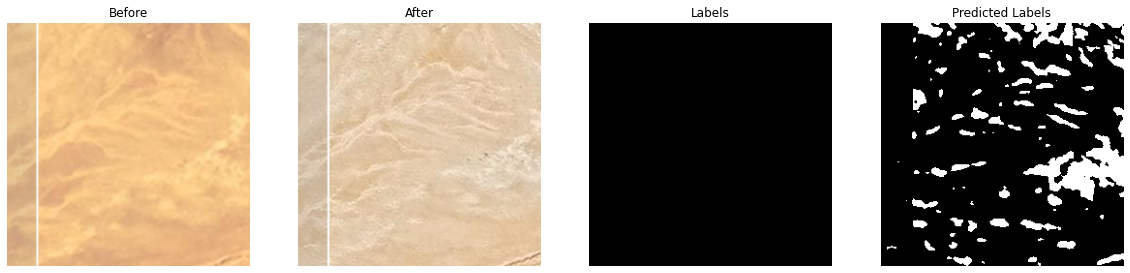

Jaccard index (IOU) for pair 1795: 0.8526848780178092
[INFO] Feature vector space size (63001, 25)


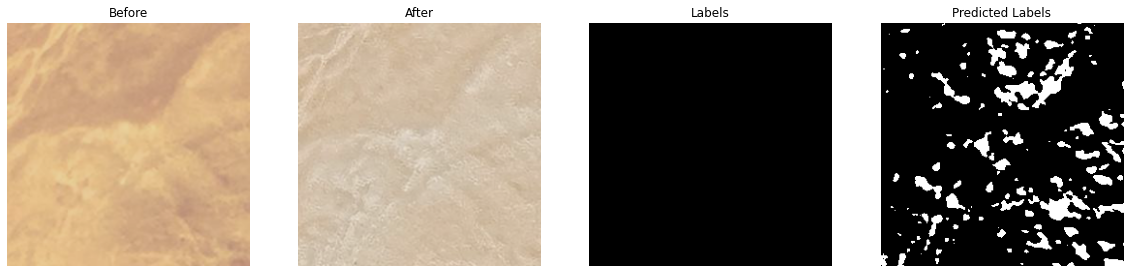

Jaccard index (IOU) for pair 1796: 0.8656846716718782
[INFO] Feature vector space size (63001, 25)


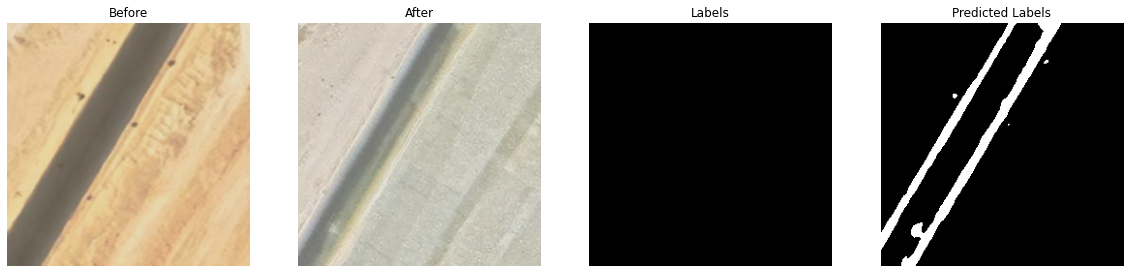

Jaccard index (IOU) for pair 1797: 0.917096554022952
[INFO] Feature vector space size (63001, 25)


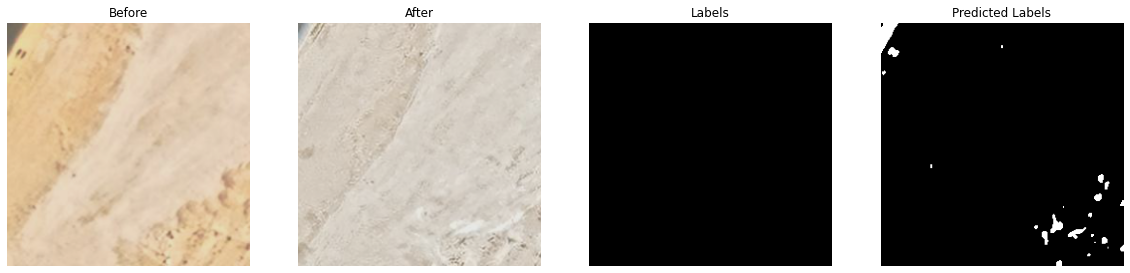

Jaccard index (IOU) for pair 1798: 0.9848891287439882
[INFO] Feature vector space size (63001, 25)


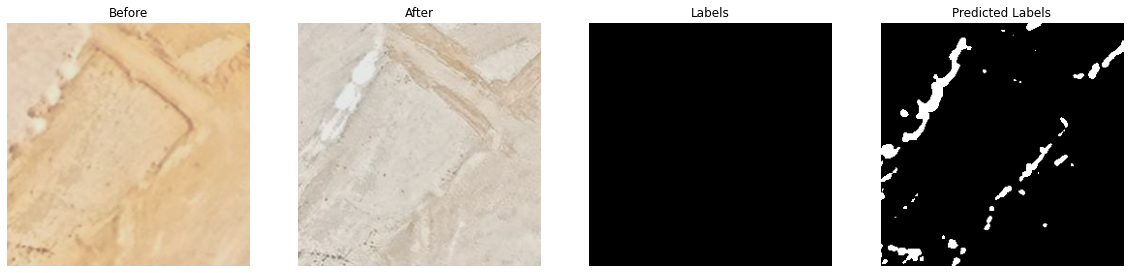

Jaccard index (IOU) for pair 1799: 0.9481436802590435


In [15]:
# Define the number of images to process
num_images = min(1800, len(before_images))

# Iterate over pairs of images and apply change detection
iou_scores = []
for i in range(4000):
    # Apply change detection code here for each pair of images
    image1 = before_images[i]
    image2 = after_images[i]
    label = labels[i]

    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_inverted = np.logical_not(change_map)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_inverted, label_binary_inverted)
    union = np.logical_or(change_map_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores.append(iou)
    
    # Print Jaccard index for each pair
    print(f'Jaccard index (IOU) for pair {i}: {iou}')



In [14]:
# Calculate mean Jaccard index
mean_iou = np.mean(iou_scores)
print(f'Mean Jaccard index (IOU) for the first 5 pairs: {mean_iou}')

print('Change detection for the first 5 pairs completed.')

Mean Jaccard index (IOU) for the first 5 pairs: 0.8200640139885299
Change detection for the first 5 pairs completed.


In [27]:
# Iterate over pairs of images and apply change detection
for i in range(len(before_images)):
    # Apply change detection code here for each pair of images
    image1 = before_images[i]
    image2 = after_images[i]
    label = labels[i]

    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.abs(image1_resized - image2_resized)
    diff_image = diff_image[:, :, 1]  # Assuming images are in BGR format and taking green channel

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Save Change Map
    cv2.imwrite(os.path.join(out_dir, f'ChangeMap_{i}.jpg'), change_map)

    # Performing Closing
    kernel = skimage.morphology.disk(6)
    CloseMap = cv2.morphologyEx(change_map, cv2.MORPH_CLOSE, kernel)
    cv2.imwrite(os.path.join(out_dir, f'CloseMap_{i}.jpg'), CloseMap)

    # Performing Opening
    OpenMap = cv2.morphologyEx(CloseMap, cv2.MORPH_OPEN, kernel)
    cv2.imwrite(os.path.join(out_dir, f'OpenMap_{i}.jpg'), OpenMap)

    print(f'Change detection completed for pair {i}')

print('Change detection for all pairs completed.')

[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 0
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 1
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 2
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 3
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 4
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 5
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 6
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 7
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 8
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 9
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 10
[INFO] Feature vector space size (63001, 25)
Change detection completed for pair 11
[I

KeyboardInterrupt: 